In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 40)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score

from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [2]:
df=pd.read_csv('../processed_data/data_processed.csv')
df['fecha']=pd.to_datetime(df.fecha,format='%Y-%m-%d %H:%M:%S')
df.head(2)

,a,b,c,d,e,f,g,h,j,k,l,m,n,p,fecha,monto,score,fraude,Country_AR,Country_BR,Country_US,Country_UY,Country_otros
0,4,0.6812,50084.12,50.0,0.0,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,1,2020-03-20 09:28:19,57.63,100,0,1,0,0,0,0
1,4,0.6694,66005.49,0.0,0.0,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,1,2020-03-09 13:58:28,40.19,25,0,1,0,0,0,0


In [3]:
cantidad = df.set_index('fecha').resample('h').count()
fraude = df.set_index('fecha').resample('h').sum()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cantidad.index, y=cantidad['a'], mode='lines', name='eventos'), secondary_y=False)
fig.add_trace(go.Scatter(x=fraude.index, y=fraude['fraude'], mode='lines', name='fraude'), secondary_y=True)
fig.update_layout(title='Gráfico de Dos Series de Tiempo', xaxis_title='Fecha')
fig.update_yaxes(title_text="a", secondary_y=False)
fig.update_yaxes(title_text="fraude", secondary_y=True)
fig.show()

#### manejo del target

#### Para contestar: ¿Qué pasos puedo seguir para intentar asegurar que la performance del modelo en laboratorio será similar a la de producción?
- Se ha decidio retirar los ultimos registros del dataset, con el fin de realizar validaciones fuera de los datos de entrenamiento. Esto nos permitirá ver el comportamiento real del modelo.
- Dado que se trata de un dataset etiquetado, se procede a realizar un modelo supervisado. Por lo tanto, algunas columnas no serán tenidas en cuenta, como la fecha, 'g' y 'j'.
- Se pensó en utilizar el día o la hora, pero están fuertemente correlacionados con la cantidad de eventos, por lo que parece no ser una variable muy significativa por sí sola.

In [4]:
df_validacion=df.sort_values(by='fecha').tail(800)
df=df[~df.index.isin(df_validacion)]
df.drop(columns=['g','j','fecha'],inplace=True)

0    0.94978
1    0.05022
Name: fraude, dtype: float64

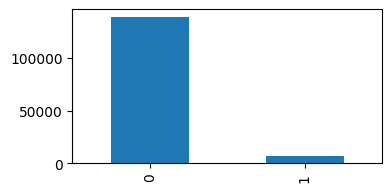

In [5]:
#dado que las clases tienen un furete des-balanceo, se realizara un sobre-muestreo a la clase fraude
df.fraude.value_counts().plot(kind='bar',figsize=(4,2))
df.fraude.value_counts(normalize=True)

In [6]:
#procedemos a realizar un sobre muestreo
X=df.drop(columns='fraude')
y=df.fraude
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

fraude
0         0.769231
1         0.230769
dtype: float64

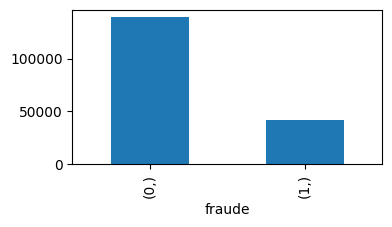

In [7]:
pd.DataFrame(y_resampled).value_counts().plot(kind='bar',figsize=(4,2))
pd.DataFrame(y_resampled).value_counts(normalize=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled , test_size=0.3, random_state=42)

##### Para comenzar, probaremos diferentes modelos con el fin de evaluar el rendimiento de cada uno. para el caso nos apoyaremos en pycaret dada la variedad de modelos y metricas

In [9]:
from pycaret.classification import *
s = setup(pd.concat([X_resampled,pd.DataFrame(y_resampled)],axis=1), target = 'fraude', session_id = 123)

,Description,Value
0,Session id,123
1,Target,fraude
2,Target type,Binary
3,Original data shape,"(181519, 20)"
4,Transformed data shape,"(181519, 20)"
5,Transformed train set shape,"(127063, 20)"
6,Transformed test set shape,"(54456, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


In [10]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9353,0.9560,0.7718,0.9369,0.8464,0.8059,0.8120,0.6600
xgboost,Extreme Gradient Boosting,0.9312,0.9542,0.7671,0.9217,0.8373,0.7941,0.7995,0.3940
rf,Random Forest Classifier,0.9245,0.9556,0.7484,0.9083,0.8206,0.7734,0.7792,3.8860
et,Extra Trees Classifier,0.9195,0.9519,0.7330,0.8997,0.8078,0.7576,0.7639,2.6180
gbc,Gradient Boosting Classifier,0.8931,0.9206,0.6365,0.8648,0.7332,0.6683,0.6806,5.8570
ada,Ada Boost Classifier,0.8816,0.9076,0.6270,0.8177,0.7097,0.6370,0.6459,1.4940
dt,Decision Tree Classifier,0.8686,0.8237,0.7403,0.7050,0.7222,0.6362,0.6365,0.2820
ridge,Ridge Classifier,0.8500,0.0000,0.4683,0.7982,0.5902,0.5059,0.5329,0.0590
lda,Linear Discriminant Analysis,0.8487,0.8613,0.5183,0.7487,0.6125,0.5223,0.5360,0.1570
knn,K Neighbors Classifier,0.8357,0.8832,0.6885,0.6324,0.6592,0.5513,0.5522,2.9380


In [11]:
print(best)
model=s.create_model('lightgbm')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9322,0.9506,0.7653,0.9284,0.8390,0.7966,0.8026
1,0.9373,0.9561,0.7736,0.9446,0.8506,0.8114,0.8179
2,0.9379,0.9586,0.7838,0.9368,0.8535,0.8145,0.8197
3,0.9371,0.9560,0.7742,0.9431,0.8503,0.8110,0.8174
4,0.9327,0.9559,0.7657,0.9304,0.8400,0.7979,0.8040
5,0.9347,0.9564,0.7664,0.9394,0.8441,0.8033,0.8100
6,0.9344,0.9579,0.7647,0.9400,0.8433,0.8024,0.8093
7,0.9359,0.9558,0.7746,0.9369,0.8480,0.8079,0.8138
8,0.9382,0.9611,0.7885,0.9334,0.8549,0.8160,0.8207


In [12]:
predict_result = s.predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9349,0.9554,0.7680,0.9387,0.8448,0.8041,0.8106


In [13]:
s.evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

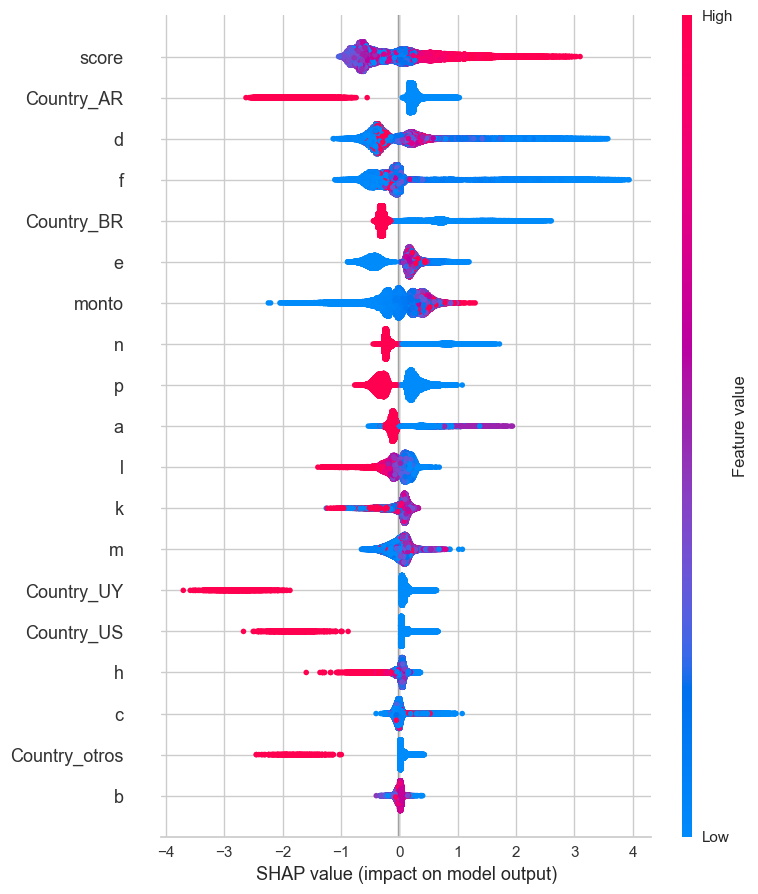

In [14]:
interpret_model(model, feature='feature_importance')

##### seleccionando mejor modelo

In [15]:
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix

In [16]:
#metricas que usaremos para medir el modelo 
def evaluate_models(y_test, y_pred):    
    print("accuracy =" ,accuracy_score(y_test, y_pred))
    print("precision =" ,precision_score(y_test, y_pred))
    print("recall =" ,recall_score(y_test, y_pred))
    print("f1_score =" ,f1_score(y_test, y_pred))
    print("roc_auc =" ,roc_auc_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

accuracy = 0.8930879976494784
precision = 0.8699465240641712
recall = 0.6384615384615384
f1_score = 0.736441828881847
roc_auc = 0.8046560257270776
[[40500  1216]
 [ 4606  8134]]


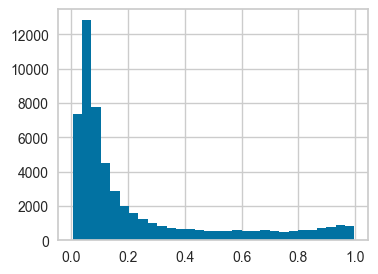

In [17]:
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)
evaluate_models(y_test, y_pred)
plt.figure(figsize=(4, 3)) 
plt.hist(y_prob[:, 1], bins=30);

In [18]:
train_data = lgb.Dataset(X_train, label=y_train)
# Definir los hiperparámetros del modelo
params = {
    "objective": "binary","metric": "binary_logloss","boosting_type": "gbdt",
    "num_leaves": 31,"subsample_for_bin":200000,"max_depth":-1,
    "min_child_samples":20, "min_child_weight":0.001,"learning_rate": 0.1,
    "feature_fraction": 0.9,"n_jobs":-1,"boosting_type":'gbdt'
}

# Entrenar el modelo LightGBM
num_round = 1000
bst = lgb.train(params, train_data, num_round)

y_pred = bst.predict(X_test)

[LightGBM] [Info] Number of positive: 29149, number of negative: 97914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 127063, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.229406 -> initscore=-1.211669
[LightGBM] [Info] Start training from score -1.211669


In [19]:
threshold = 0.55
y_pred_binario = (y_pred > threshold).astype(int)
evaluate_models(y_test, y_pred_binario)

accuracy = 0.9528793888644043
precision = 0.9730332899386275
recall = 0.8213500784929356
f1_score = 0.8907806248403848
roc_auc = 0.9071991546937782
[[41426   290]
 [ 2276 10464]]


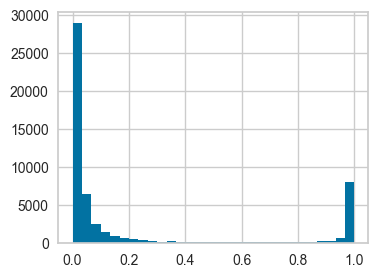

In [20]:
plt.figure(figsize=(4, 3)) 
plt.hist(y_pred, bins=30);

#### tenemos que determinar el punto de corte para contestar la pregunta de maximizar la ganacia, esto nos permite utilizar el modelo en benefico de la empresa

In [21]:
def definir_corte_optimo(y_test, y_prob, costo_fp, costo_fn, beneficio_tp, beneficio_tn):
    corte = np.arange(0, 1, 0.01) 
    
    punto_optimo = None
    max_rentabilidad = -float('inf')
    
    for threshold in corte:
        y_pred = (y_prob >= threshold).astype(int)        
        tp = np.sum((y_test == 1) & (y_pred == 1))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        tn = np.sum((y_test == 0) & (y_pred == 0))
        fn = np.sum((y_test == 1) & (y_pred == 0))        
        rentabilidad = tp * beneficio_tp + tn * beneficio_tn - fp * costo_fp - fn * costo_fn        
        if rentabilidad > max_rentabilidad:
            max_rentabilidad = rentabilidad
            punto_optimo = threshold    
    return punto_optimo, max_rentabilidad

In [22]:
costo_fp = 1.0  # Costo de un falso positivo FP es todo ya que se pierde el ingreso por error del modelo
costo_fn = 1.0  # Costo de un falso negativo FN es todo ya que el modelo no lo pudo detectar
beneficio_tp = 0.0  # Detectar el fraude es bueno no genera costos, pero no genera ganacia adicional al ingreso
beneficio_tn = 0.25  # Detectar los no fraudes correctamente ayuda a generar ese 25% adicional de ganacia
definir_corte_optimo(y_test, y_pred, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

(0.51, 7805.25)

#### Probaremos el modelo utilizando el conjunto de datos de validación para evaluar su rendimiento en datos que no se utilizaron durante el entrenamiento. Esto nos proporcionará una breve aproximación de su comportamiento en un entorno de producción

In [23]:
y_pred = bst.predict(df_validacion[X.columns])
threshold = 0.51
y_pred_binario = (y_pred > threshold).astype(int)
evaluate_models(df_validacion.fraude, y_pred_binario)

costo_fp = 1.0 
costo_fn = 1.0 
beneficio_tp = 1
beneficio_tn = 0.25 
definir_corte_optimo(df_validacion.fraude, y_pred_binario, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

accuracy = 0.97125
precision = 0.8846153846153846
recall = 0.5348837209302325
f1_score = 0.6666666666666665
roc_auc = 0.7654603545205985
[[754   3]
 [ 20  23]]


(0.01, 188.5)

In [24]:
df_validacion['pred']=y_pred_binario
df_validacion[['fraude','pred','monto']]

print("total transacciones", df_validacion.monto.sum())
print("transacciones bien clasificadas", df_validacion[(df_validacion.pred==0) & (df_validacion.fraude==0)].monto.sum())
print("fraude evitado", df_validacion[(df_validacion.pred==1) & (df_validacion.fraude==1)].monto.sum())
print("fraude no visto", df_validacion[(df_validacion.pred==0) & (df_validacion.fraude==1)].monto.sum())

total transacciones 32911.49
transacciones bien clasificadas 30194.88
fraude evitado 1719.88
fraude no visto 940.0000000000001


In [25]:
y_pred=xgb_classifier.predict_proba(df_validacion[X.columns])
threshold = 0.55
y_pred_binario = (y_pred[:, 1] > threshold).astype(int)
evaluate_models(df_validacion.fraude, y_pred_binario)

costo_fp = 1.0 
costo_fn = 1.0 
beneficio_tp = 0
beneficio_tn = 0.25 
definir_corte_optimo(df_validacion.fraude, y_pred_binario, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

accuracy = 0.94125
precision = 0.4411764705882353
recall = 0.3488372093023256
f1_score = 0.38961038961038963
roc_auc = 0.6618690670025499
[[738  19]
 [ 28  15]]


(0.01, 137.5)

## resumen
### Después de realizar validaciones de modelos de clasificación, se observó que los modelos basados en árboles son especialmente precisos en este tipo de problemas. Además, el equilibrio de las clases demostró ser útil para mejorar el rendimiento del modelo.
- Sobre-muestreo de la clase fraude: Inicialmente, la clase fraude representaba solo un 5% de los casos, pero mediante el sobre-muestreo se logró aumentar su proporción al 23%. No se buscó lograr un equilibrio de 50%-50% entre las clases, ya que se prefirió mantener ese criterio para fines de evaluación.
- Selección del modelo: En la elección del modelo, se optó por el Light Gradient Boosting Machine, que superó por poco al segundo mejor modelo, el XGBoost. Sin embargo, cabe destacar que XGBoost sigue siendo una sólida opción.
- Matriz de costos: Se creó una matriz de costos que permite determinar el punto de corte óptimo para maximizar los beneficios con el modelo, el cual se estableció en 0.55.
- Al revisar contra el dataset de validación el modelo baja su desempeño pero sigue siendo una buena opción para rentabilizar y llevar producción y reentrenar

In [26]:
X

,a,b,c,d,e,f,h,k,l,m,n,p,monto,score,Country_AR,Country_BR,Country_US,Country_UY,Country_otros
0,4,0.6812,50084.12,50.0,0.000000,20.0,1,0.365475,2479.0,952.0,1,1,57.63,100,1,0,0,0,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,1,0.612728,2603.0,105.0,1,1,40.19,25,1,0,0,0,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,25,0.651835,2153.0,249.0,1,1,5.77,23,0,1,0,0,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,43,0.692728,4845.0,141.0,1,1,40.89,23,0,1,0,0,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,0,0.201354,2856.0,18.0,1,0,18.98,71,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147008,4,0.2949,22356.33,6.0,0.000000,0.0,3,0.859495,3331.0,32.0,1,0,26.71,62,0,1,0,0,0
147009,4,0.7728,34031.44,3.0,0.341379,18.0,18,0.685681,2475.0,39.0,1,0,5.47,37,0,1,0,0,0
147010,4,0.7012,77840.16,34.0,0.179331,3.0,32,0.315430,2497.0,219.0,1,1,6.28,57,0,1,0,0,0
147011,2,0.7206,31001.65,50.0,0.000000,50.0,31,0.813346,3952.0,84.0,1,0,40.52,0,0,0,0,1,0
